In [1]:
import numpy as np
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# path = Path("../results/24-02-28_19-08-37-829356")

path = Path("../results/24-04-05_12-04-02-790756/")
path_metrics = path / "metrics"

In [3]:
def flatten_dictionary(cfg):
    def items(cfg):
        for k, v in cfg.items():
            if isinstance(v, dict):
                for sub_k, sub_v in items(v):
                    yield (f"{k}.{sub_k}", sub_v)
            else:
                yield (k, v)

    return dict(items(cfg))

In [4]:
cfg = yaml.load(open(path / "cfg.yaml", "r"), Loader=yaml.FullLoader)
cfg_flatten = flatten_dictionary(cfg)

df = pd.DataFrame(cfg_flatten, index=[0])

In [5]:
df

,batch_size,criterion,dataset,dataset_test_params.data_csv_path,dataset_test_params.dataset_parent_folder,dataset_test_params.dataset_type,dataset_test_params.event_encoding_method,dataset_test_params.img_size,dataset_test_params.transform,dataset_train_params.data_csv_path,...,optimizer,optimizer_params.lr,optimizer_params.weight_decay,path_to_save,saving_checkpoint,scheduler,scheduler_params.factor,scheduler_params.mode,scheduler_params.patience,scheduler_params.threshold
0,16,CrossEntropyLoss,CustomDefectDataSet,/dtu/eumcaerotrain/data/latest_dataset/test_fi...,/dtu/eumcaerotrain/data/latest_dataset,npz_event_based,1,224,False,/dtu/eumcaerotrain/data/latest_dataset/night_o...,...,Adam,0.001,0.0005,./results,10,ReduceLROnPlateau,0.5,max,5,0.001


In [6]:
def get_best_score(metric, data, operation="min"):
    if operation == "min":
        op = np.argmin
    elif operation == "max":
        op = np.argmax
    else:
        raise ValueError(f"Operation {operation} not supported")

    epoch = op(data[metric])
    
    new_data = {"epoch": epoch, "metric_saved [metric | operation]": f"{metric} | {operation}"}
    for k, v in data.items():
        new_data[k] = v[epoch]
    
    df = pd.DataFrame(new_data, index=[0])
    return df

In [7]:
metrics = {}
for file in path_metrics.glob("*.npy"):
    metrics[file.stem] = np.load(file)

print(list(metrics.keys()))

['train_accs', 'f1_scores_train', 'valid_losses', 'f1_scores_valid', 'valid_accs', 'train_losses']


In [8]:
df_metric = get_best_score("valid_losses", metrics, "min")
final_df = pd.concat([df, df_metric], axis=1)
    
final_df

,batch_size,criterion,dataset,dataset_test_params.data_csv_path,dataset_test_params.dataset_parent_folder,dataset_test_params.dataset_type,dataset_test_params.event_encoding_method,dataset_test_params.img_size,dataset_test_params.transform,dataset_train_params.data_csv_path,...,scheduler_params.patience,scheduler_params.threshold,epoch,metric_saved [metric | operation],train_accs,f1_scores_train,valid_losses,f1_scores_valid,valid_accs,train_losses
0,16,CrossEntropyLoss,CustomDefectDataSet,/dtu/eumcaerotrain/data/latest_dataset/test_fi...,/dtu/eumcaerotrain/data/latest_dataset,npz_event_based,1,224,False,/dtu/eumcaerotrain/data/latest_dataset/night_o...,...,5,0.001,34,valid_losses | min,91.213235,0.911402,0.32748,0.887205,88.946015,0.228653


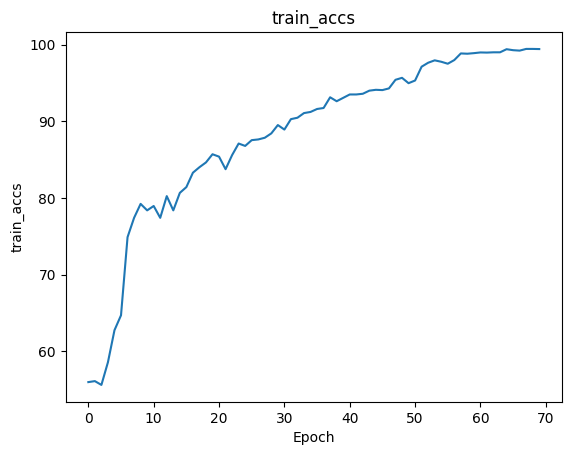

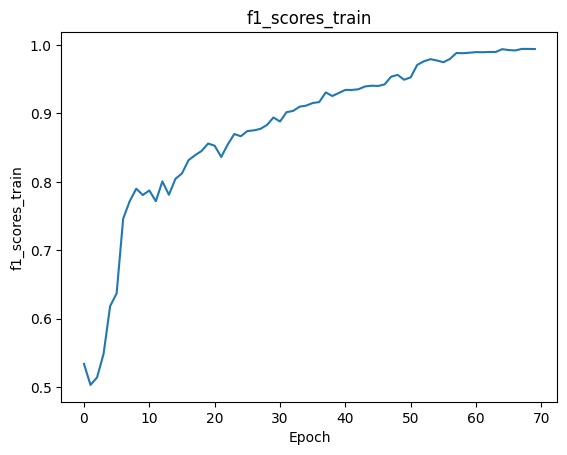

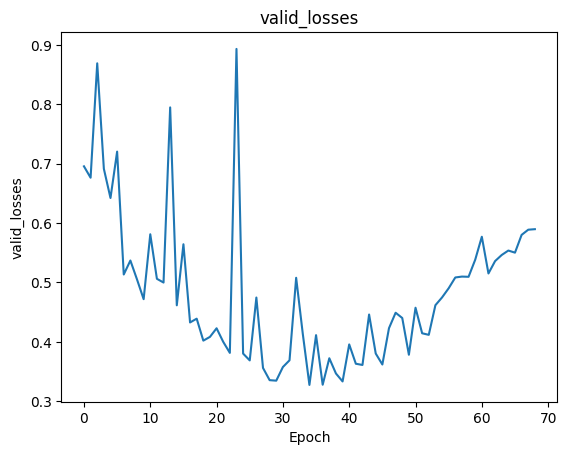

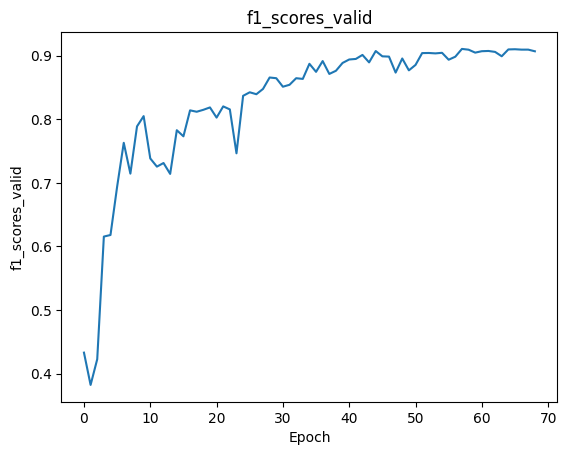

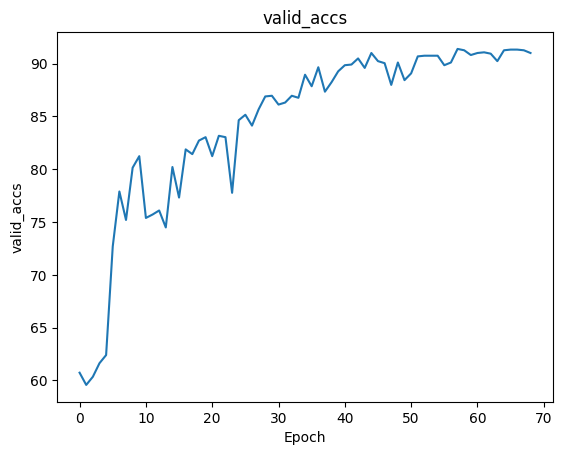

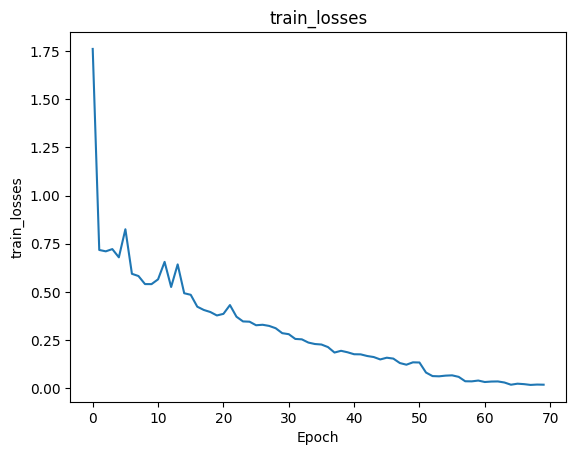

In [9]:
for k, v in metrics.items():
    plt.figure()
    plt.plot(v)
    plt.title(k)
    plt.xlabel("Epoch")
    plt.ylabel(k)